**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Classroom code**: [wv4cglx]

# 10: Métrica para evaluación

La metrica seleccionada para evaluar el desempeño del modelo es muy importante. Las métricas para los algoritmos de regresión y clasificación son diferentes, a continuación se presenta cada una de ellas:

## Métrica de clasificación

###  Accuracy
Es la relación entre todas las predicciones y el número de predicciones correctas. Es útil solo cuando hay un número igual de observaciones en cada clase y todas las predicción y errores son igualmente importantes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter("ignore")

In [3]:
data= pd.read_excel('G:\My Drive\ANALISIS ESPACIAL APLICADO\datos\Cuencas_torrencialidad.xlsx', sheet_name='Hoja2')
X=data.drop(['Name', 'Flash flood record'],axis=1)
y=data['Flash flood record']

In [4]:
kfold = KFold(n_splits=5, random_state=1)
model = LogisticRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
print(results.mean())
print(results.std())

0.8
0.2231093404090868


### Logarithmic Loss
El *Logarithmic loss (logloss)* es una métrica para evaluar la predicción de las probabilidades de pertenecer a uan clase. El valor esta entre 0 y 1 y puede ser vista de la confiabilidad de la predicción del algoritmo.

In [14]:
kfold = ShuffleSplit(n_splits=5, random_state=1)
model = LogisticRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='neg_log_loss')
print(results.mean())
print(results.std())

-0.5181855810141769
0.5082397657627405


### Confusión Matrix
La Matriz de Confusión es una representación de los resultados de un modelo con dos o mas clases. En el eje X representa las predicciones y en el eje Y las observaciones. 

In [5]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[16  0]
 [ 1  5]]


Para presentar la matriz un poco mas elegante se puede utilizar el siguiente código:

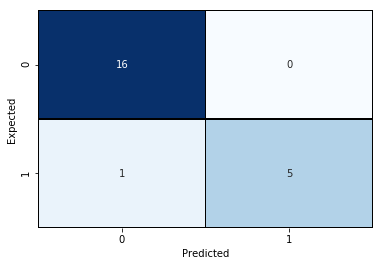

In [23]:
import seaborn as sns
sns.heatmap(matrix, annot=True, cbar=False, linecolor='black',linewidths=0.7,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Reporte de clasificación
La librearía de *scikit-learn* genera un reporte con las principales métricas. 

In [87]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.83      0.91         6

    accuracy                           0.95        22
   macro avg       0.97      0.92      0.94        22
weighted avg       0.96      0.95      0.95        22



### Curva ROC 

Para obtener la curva ROC es necesario utilizar la función *predict_proba* la cual arroja las probabilidades de cada observación de pertenecer a las clases [0,1]. En este caso vamos a utilizar solamente la columna dos, que representa la probabilidad que sea 1, es decir torrencial.

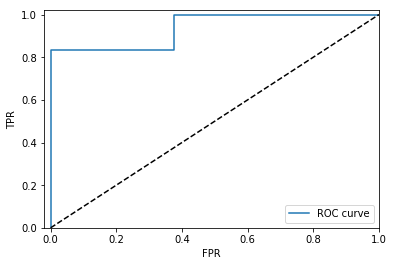

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

probs=model.predict_proba(X_test)
y_pred_proba = probs[:,1]

fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
plt.plot(fpr,tpr, label='ROC curve')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.02,1.0])
plt.ylim([0.0,1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4);

Para encontrar el punto mas cercano a la esquina superior izquierda, el cual corresponde al mejor umbral para clasificar las clases, se utiliza el siguiente código.

   fpr       tpr  1-fpr        tf  threshold
2  0.0  0.833333    1.0 -0.166667   0.938309


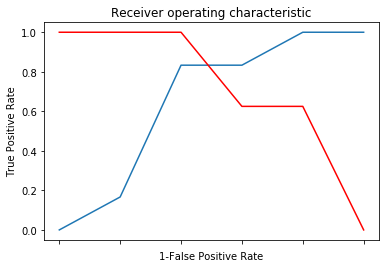

In [125]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
best=roc.ix[(roc.tf-0).abs().argsort()[:1]]
print(best)

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'],label='TPR')
plt.plot(roc['1-fpr'], color = 'red',label='1-FPR')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([]);

El mejor umbral corresponde entonces a:

In [126]:
best_threshold=list(best['threshold'])
print(best_threshold)

[0.9383085178375764]


Por defecto Scikit Learn define el umbral como 0.5, si cambiamos este valor por el umbral que optimiza la función y recien encontrado, entonces podemos mejorar la clasificación, en este caso la matriz de confusión, de la siguiente manera:

In [128]:
y_pred_best=np.where(y_pred_proba>=best_threshold,1,0)
matrix = confusion_matrix(y_test, y_pred_best)
print(matrix)

[[16  0]
 [ 1  5]]


### Área bajo la curva ROC
EL area bajo la curva (AUC) es uan métrica para clasificaciones binarias. y representa la capacidad de discriminar entre clases positivo y negativo. Un AUC de 1 representa que todas las predicciones son correctas, un valor de 0.5 representa que es un resultado aleatorio

La curva ROC puede ser dividida entre sensibilidad y Especificidad. Una clasificación binaria es en realidad un trade-off entre Sensibilidad y Especificidad, donde:
- Sensivilidad: es el *true positive rate* tambien llaamdo *recall*. Es el número de observaciones de la clase positiva que realmente la predcción fue correcta.
- Especificidad: tambien llamada *true negative rate*. es el número de observaciones de la clase negativa donde la predicción fue correcta. 

In [19]:
kfold = ShuffleSplit(n_splits=5, random_state=1)
model = LogisticRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
print('{:.3f}'.format(results.mean()))

0.973


Otra funcion para obtener el valor del area bajo la curva ROC es:

In [21]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test,y_pred_proba))

0.9375


### Curva *Precision-Recall*

Para casos de clasificacion con un desbalance de datos y donde precisamente la clase minoritaria es la de mayor interes, posiblemente la curva *Precision-Recall* es de mayor informacion que la curva ROC, ya que en su estimacion no cosndera lso veradderos negativos. Los cuales corresponden a la mayoria de la clase dominante, por lo tanto el modelo se entreno lo suficientemtne bien para predecir dicha clase. Peroen estso casos los errores se encuentran en establecer los falsos negativos, ya que el modelo al tener tan pocos datso de la clase 1 no predeci celdas con estas carcateristicas.

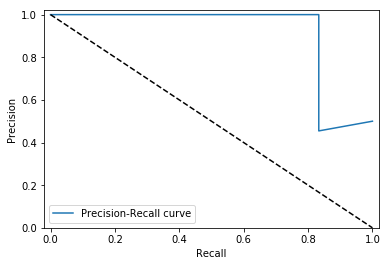

In [22]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred_proba)
plt.plot(recall, precision,  label='Precision-Recall curve')
plt.plot([0,1],[1,0],'k--')
plt.xlim([-0.02,1.02])
plt.ylim([0.0,1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3);

Para calcular el area bajo la curva *Precision-Recall* se utiliza la funcion *auc*.

In [26]:
from sklearn.metrics import auc
print(auc(recall, precision))

0.9128787878787878


El valor F1 estima la media armonica entre la precision y el *recall*

In [25]:
from sklearn.metrics import f1_score
print(f1_score(y_test,predicted ))

0.9090909090909091


## Métrica para metodos de regresión

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
X,y=load_boston(return_X_y=True)

### Mean Absolute Error
El error medio absoluto (MAE) es la suma de las diferencias absolutas entre las predicciones y las observaciones. Da una idea de que tan equivocado puede estar el modelo, define la magnitud pero no la direccion, (*over* o *under fitting*).

In [23]:
kfold = KFold(n_splits=5, random_state=1)
model = LinearRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(results.mean())
print(results.std())

-4.249968544192532
0.9792537069067512


### Mean Squared Error
El error medio cuadrático (MSE) es mas como el error medio absoluto ya qu da una idea de la magnitud del error en las unidades del problema, tambien es denominado *Root Mean Squared Error -RMSE-*.

In [37]:
kfold = KFold(n_splits=5, random_state=1)
model = LinearRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
print(results.mean())
print(results.std())

-37.13180746769914
23.091945335664057


### R2 Metric
Finalmente el R2 (R cuadrado) provee una buena indicación del la bondad del ajuste de las predicciones a las observaciones, y varía entre 0 y 1.

In [24]:
kfold = KFold(n_splits=5, random_state=1)
model = LinearRegression()
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results.mean())
print(results.std())

0.35327592439588124
0.3765678393326169
